# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### 데이터 셋 읽어오기

In [2]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [3]:
df_train.head() # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.0,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.0,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.0,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.0,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True


In [4]:
df_test.head()

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,...,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,1
1,9738,0.25,400 N State Of Franklin Rd Cloud IT / Johnson...,IT,NaN,5405,End Customer,SMB,NaN,NaN,...,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,1
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,NaN,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,1
3,19895,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,NaN,194,0
4,10465,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,1


## 2. 데이터 전처리

### 레이블 인코딩

In [5]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [6]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

다시 학습 데이터와 제출 데이터를 분리합니다.

In [7]:
for col in label_columns:  
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

### 2-2. 학습, 검증 데이터 분리

In [10]:
# ! pip install imbalanced-learn

In [11]:
from imblearn.under_sampling import RandomUnderSampler

# Random Undersampling 적용
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(df_train.drop("is_converted", axis=1),df_train["is_converted"])

In [12]:
x_train, x_val, y_train, y_val = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    shuffle=True,
    random_state=400,
)

## 3. 모델 학습

### 모델 정의 

In [13]:
# model = DecisionTreeClassifier() # undersampling-> 0.53 : 0.85

from sklearn.ensemble import RandomForestClassifier # 0.63 : 0.91
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# model = RandomForestClassifier(random_state = 42)
model = XGBClassifier(random_state = 42)

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}


kf = StratifiedKFold(shuffle = True, random_state = True)
search = GridSearchCV(estimator=model, param_grid =param_grid,
                                    cv=kf, scoring='f1')

search.fit(x_train.fillna(0), y_train)


NameError: name 'grid_search' is not defined

In [17]:
# 최적의 하이퍼파라미터 출력
print("Best parameters:", search.best_params_)

# 최적의 모델 출력
best_model = search.best_estimator_
best_model

Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### 모델 학습

In [18]:
model = XGBClassifier(random_state = 42,
                      colsample_bytree = 0.6, 
                      learning_rate = 0.2, 
                      max_depth = 7,
                      min_child_weight = 1,
                      n_estimators = 300,
                      subsample = 1.0)
model.fit(x_train.fillna(0), y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### 모델 성능 보기

In [19]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [20]:
pred = model.predict(x_val.fillna(0))
get_clf_eval(y_val, pred)

오차행렬:
 [[914  52]
 [ 74 900]]

정확도: 0.9351
정밀도: 0.9251
재현율: 0.9462
F1: 0.9355


## feature importance 확인

In [21]:
df_train.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_country.1', 'customer_position',
       'response_corporate', 'expected_timeline', 'ver_cus', 'ver_pro',
       'ver_win_rate_x', 'ver_win_ratio_per_bu', 'business_area',
       'business_subarea', 'lead_owner', 'is_converted'],
      dtype='object')

In [22]:
model.feature_importances_

array([0.01866216, 0.01666975, 0.08254781, 0.04107452, 0.10895414,
       0.10077051, 0.02039271, 0.03801637, 0.02990453, 0.00746967,
       0.00619241, 0.01457185, 0.01969911, 0.02980171, 0.02377423,
       0.01821237, 0.01555858, 0.00763788, 0.01337102, 0.04791146,
       0.02195359, 0.05872972, 0.01424481, 0.03730172, 0.01921702,
       0.01186196, 0.1290084 , 0.04649005], dtype=float32)

In [23]:
df_train.head()

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,9070,0,0.066667,32160,10,0,NaN,NaN,NaN,...,33,246,1,0,0.003079,0.026846,0,28,0,True
1,1.0,8406,0,0.066667,23122,10,0,12.0,NaN,NaN,...,33,246,1,0,0.003079,0.026846,0,0,1,True
2,1.0,6535,0,0.088889,1755,10,0,144.0,NaN,NaN,...,21,246,1,0,0.003079,0.026846,0,17,2,True
3,1.0,3388,0,0.088889,4919,10,0,NaN,NaN,NaN,...,21,246,1,0,0.003079,0.026846,0,44,3,True
4,1.0,5799,0,0.088889,17126,29,0,NaN,NaN,NaN,...,21,246,0,0,0.003079,0.026846,0,86,4,True


In [24]:
from xgboost import plot_importance

fscore = model.get_booster().get_fscore()
fscore

{'bant_submit': 260.0,
 'customer_country': 1075.0,
 'business_unit': 129.0,
 'com_reg_ver_win_rate': 363.0,
 'customer_idx': 1511.0,
 'customer_type': 397.0,
 'enterprise': 179.0,
 'historical_existing_cnt': 211.0,
 'id_strategic_ver': 16.0,
 'it_strategic_ver': 2.0,
 'idit_strategic_ver': 7.0,
 'customer_job': 502.0,
 'lead_desc_length': 1121.0,
 'inquiry_type': 278.0,
 'product_category': 480.0,
 'product_subcategory': 262.0,
 'product_modelname': 205.0,
 'customer_country.1': 422.0,
 'customer_position': 439.0,
 'response_corporate': 679.0,
 'expected_timeline': 224.0,
 'ver_cus': 28.0,
 'ver_pro': 35.0,
 'ver_win_rate_x': 217.0,
 'ver_win_ratio_per_bu': 166.0,
 'business_area': 139.0,
 'business_subarea': 221.0,
 'lead_owner': 1684.0}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

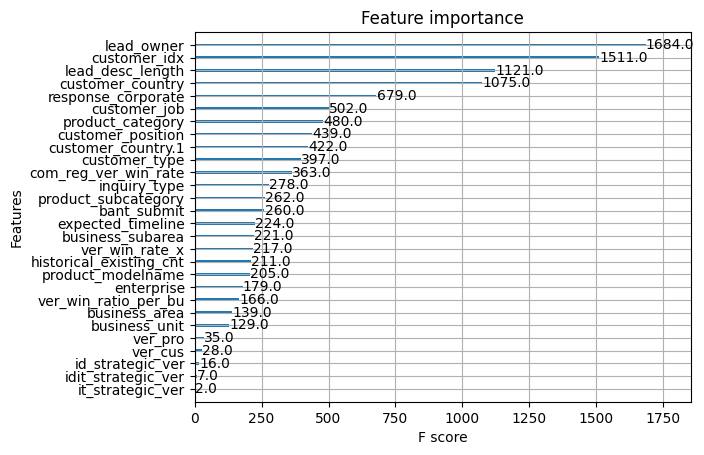

In [25]:
plot_importance(model)

## 4. 제출하기

### 테스트 데이터 예측

In [26]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [27]:
test_pred = model.predict(x_test.fillna(0))
sum(test_pred) # True로 예측된 개수

1876

### 제출 파일 작성

In [29]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**